In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import requests
import json
from bs4 import BeautifulSoup
from PIL import Image
from urllib.request import urlopen
from mplsoccer import Pitch, add_image, FontManager
import LanusStats as ls
sofascore = ls.SofaScore()
from urllib.error import HTTPError

DATOS QUE SE DEBEN EDITAR

In [2]:
url = 'https://www.sofascore.com/football/match/deportes-tolima-atletico-nacional/gxcslxc#id:13222205'
jug_heatmap_loc = 'Andrés Román'
jug_heatmap_vis = 'Juan Pablo Nieto'
color_loc = 'green'
color_vis = 'yellow'

In [3]:
partido_sofascore = sofascore.get_match_data(url)

In [4]:
nombre_local, nombre_visit = sofascore.get_team_names(url)
nombre_local
nombre_visit

'Deportes Tolima'

SACAR MATCH MOMENTUM

In [5]:
match_momentum= sofascore.get_match_momentum(url)
match_momentum

,minute,value
0,1.0,2
1,2.0,3
2,3.0,11
3,4.0,12
4,5.0,42
...,...,...
87,87.0,1
88,88.0,-8
89,89.0,-10
90,90.0,-54


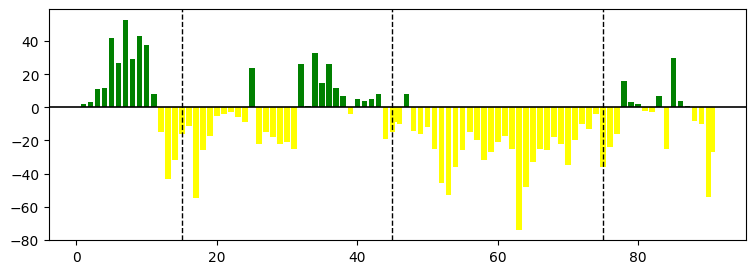

In [6]:
fig, ax = plt.subplots(figsize=(9,3))
match_momentum_local = match_momentum[match_momentum['value'] > 0]
match_momentum_visit = match_momentum[match_momentum['value'] < 0]

plt.bar(match_momentum_local.minute, match_momentum_local.value, color=color_loc)
plt.bar(match_momentum_visit.minute, match_momentum_visit.value, color=color_vis)

# Líneas verticales punteadas para momentos clave (opcional, por ejemplo, minuto 45, etc.)
ax.axvline(x=45, color='black', linestyle='--', linewidth=1)
ax.axvline(x=15, color='black', linestyle='--', linewidth=1)
ax.axvline(x=75, color='black', linestyle='--', linewidth=1)

# Añadir la línea horizontal en el valor 0
ax.axhline(0, color='black', linewidth=1.2)


Mapa calor visitante

In [7]:
mapa_calor_jug_vis = sofascore.get_player_heatmap(url, player=jug_heatmap_vis)

Mapa calor local

In [8]:
mapa_calor_jug_loc = sofascore.get_player_heatmap(url, player=jug_heatmap_loc)

SACAR JUFADORES DESTACADOS

In [9]:
df_local = sofascore.get_players_match_stats(url)[0]
df_visit = sofascore.get_players_match_stats(url)[1]

In [10]:
df_local['percentage_pass'] = (df_local['accuratePass'] / df_local['totalPass']) * 100
df_visit['percentage_pass'] = (df_visit['accuratePass'] / df_visit['totalPass']) * 100

In [11]:
df_filtrado = df_visit[['shortName','touches','totalPass','keyPass','percentage_pass']]
df_filtrado 

,shortName,touches,totalPass,keyPass,percentage_pass
0,W. Cuesta,23.0,15.0,NaN,100.000000
1,J. Quiñónes,63.0,57.0,NaN,84.210526
2,J. Quiñones,56.0,51.0,NaN,94.117647
3,M. Torres,36.0,34.0,NaN,100.000000
4,Y. Hurtado,81.0,62.0,NaN,95.161290
5,B. Rovira,71.0,67.0,1.0,91.044776
6,J. P. Nieto,81.0,73.0,NaN,93.150685
7,Y. Rosales,53.0,30.0,NaN,86.666667
8,Y. Guzmán,87.0,76.0,2.0,85.526316
9,A. Castro,65.0,43.0,1.0,90.697674


In [12]:
lista_mayores = ['duelWon', 'touches', 'keyPass','percentage_pass']
nombre_mayores_local = []
valor_mayores_local = []
nombre_mayores_visit = []
valor_mayores_visit = []

for i in range(len(lista_mayores)):
    nombre = df_local.sort_values(by=lista_mayores[i], ascending=False)[['name', lista_mayores[i]]].values[0][0]
    valor = df_local.sort_values(by=lista_mayores[i], ascending=False)[['name', lista_mayores[i]]].values[0][1]
    nombre_mayores_local.append(nombre)
    valor_mayores_local.append(valor)

for i in range(len(lista_mayores)):
    nombre = df_visit.sort_values(by=lista_mayores[i], ascending=False)[['name', lista_mayores[i]]].values[0][0]
    valor = df_visit.sort_values(by=lista_mayores[i], ascending=False)[['name', lista_mayores[i]]].values[0][1]
    nombre_mayores_visit.append(nombre)
    valor_mayores_visit.append(valor)

nombre_mayores_local, valor_mayores_local

(['Jorman Campuzano', 'Jorman Campuzano', 'Marino Hinestroza', 'Juan Zapata'],
 [7.0, 46.0, 5.0, 90.0])

In [13]:
nombre_mayores_visit, valor_mayores_visit

(['Yhorman Hurtado', 'Yeison Guzmán', 'Yeison Guzmán', 'William Cuesta'],
 [4.0, 87.0, 2.0, 100.0])

In [14]:
def sacar_spines(ax):
    ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

SACAR ESCUDOS

In [15]:
idlocal = partido_sofascore['event']['homeTeam']['id']
idvisit = partido_sofascore['event']['awayTeam']['id']

In [16]:
imagen1 = Image.open(urlopen(f'https://api.sofascore.app/api/v1/team/{idlocal}/image'))
imagen2 = Image.open(urlopen(f'https://api.sofascore.app/api/v1/team/{idvisit}/image'))

SACAR INFO DEL PARTIDO

In [17]:
goleslocal = partido_sofascore['event']['homeScore']['normaltime']
golesvisit = partido_sofascore['event']['awayScore']['normaltime']

torneo = partido_sofascore['event']['season']['name']
fecha = partido_sofascore['event']['roundInfo']['round']

MAPAS DE TIROS

In [18]:
shotmap = sofascore.get_match_shotmap(url)
tiros = shotmap[['isHome','shotType', 'name','id','x','y']]
tiros

,isHome,shotType,name,id,id,x,y
0,False,miss,Luis Miranda,4187684,891115,30.1,74.4
1,False,miss,Brayan Gil,4187683,1065361,14.8,48.1
2,True,block,Juan Zapata,4187682,983231,10.3,35.6
3,True,block,Kevin Viveros,4187681,925124,14.5,50.9
4,True,miss,Kevin Viveros,4187679,925124,13.0,47.9
5,True,block,Juan Zapata,4187680,983231,10.5,68.1
6,True,block,Kevin Viveros,4187678,925124,27.0,35.2
7,False,save,Yeison Guzmán,4187677,870359,11.5,50.0
8,False,block,Brayan Gil,4187676,1065361,12.8,56.3
9,False,miss,Juan Pablo Nieto,4187675,338861,23.7,69.1


In [19]:
partido_sofascore

{'event': {'tournament': {'name': 'Primera A, Clausura, Playoffs',
   'slug': 'primera-a-clausura-playoffs',
   'category': {'name': 'Colombia',
    'slug': 'colombia',
    'sport': {'name': 'Football', 'slug': 'football', 'id': 1},
    'id': 274,
    'country': {'alpha2': 'CO',
     'alpha3': 'COL',
     'name': 'Colombia',
     'slug': 'colombia'},
    'flag': 'colombia',
    'alpha2': 'CO'},
   'uniqueTournament': {'name': 'Primera A, Finalización',
    'slug': 'primera-a-clausura',
    'primaryColorHex': '#002c6d',
    'secondaryColorHex': '#00afcf',
    'category': {'name': 'Colombia',
     'slug': 'colombia',
     'sport': {'name': 'Football', 'slug': 'football', 'id': 1},
     'id': 274,
     'country': {'alpha2': 'CO',
      'alpha3': 'COL',
      'name': 'Colombia',
      'slug': 'colombia'},
     'flag': 'colombia',
     'alpha2': 'CO'},
    'userCount': 20780,
    'id': 11536,
    'country': {},
    'hasPerformanceGraphFeature': False,
    'hasEventPlayerStatistics': True,
 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


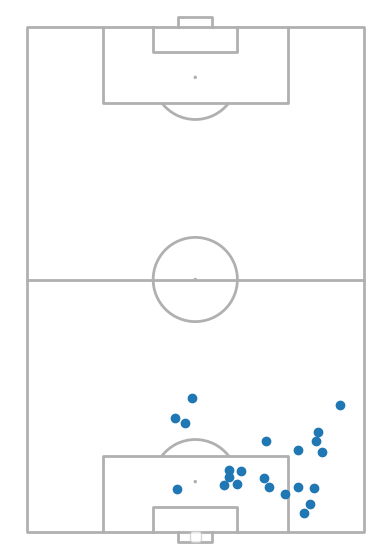

In [20]:
from mplsoccer import VerticalPitch, Pitch
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,7))
pitch = VerticalPitch(
    pitch_type='statsbomb',
    goal_type='box'
)

pitch.draw(ax=ax)

##plt.ylim(80, 125)

pitch.scatter(tiros.x, tiros.y, ax=ax)

plt.legend()

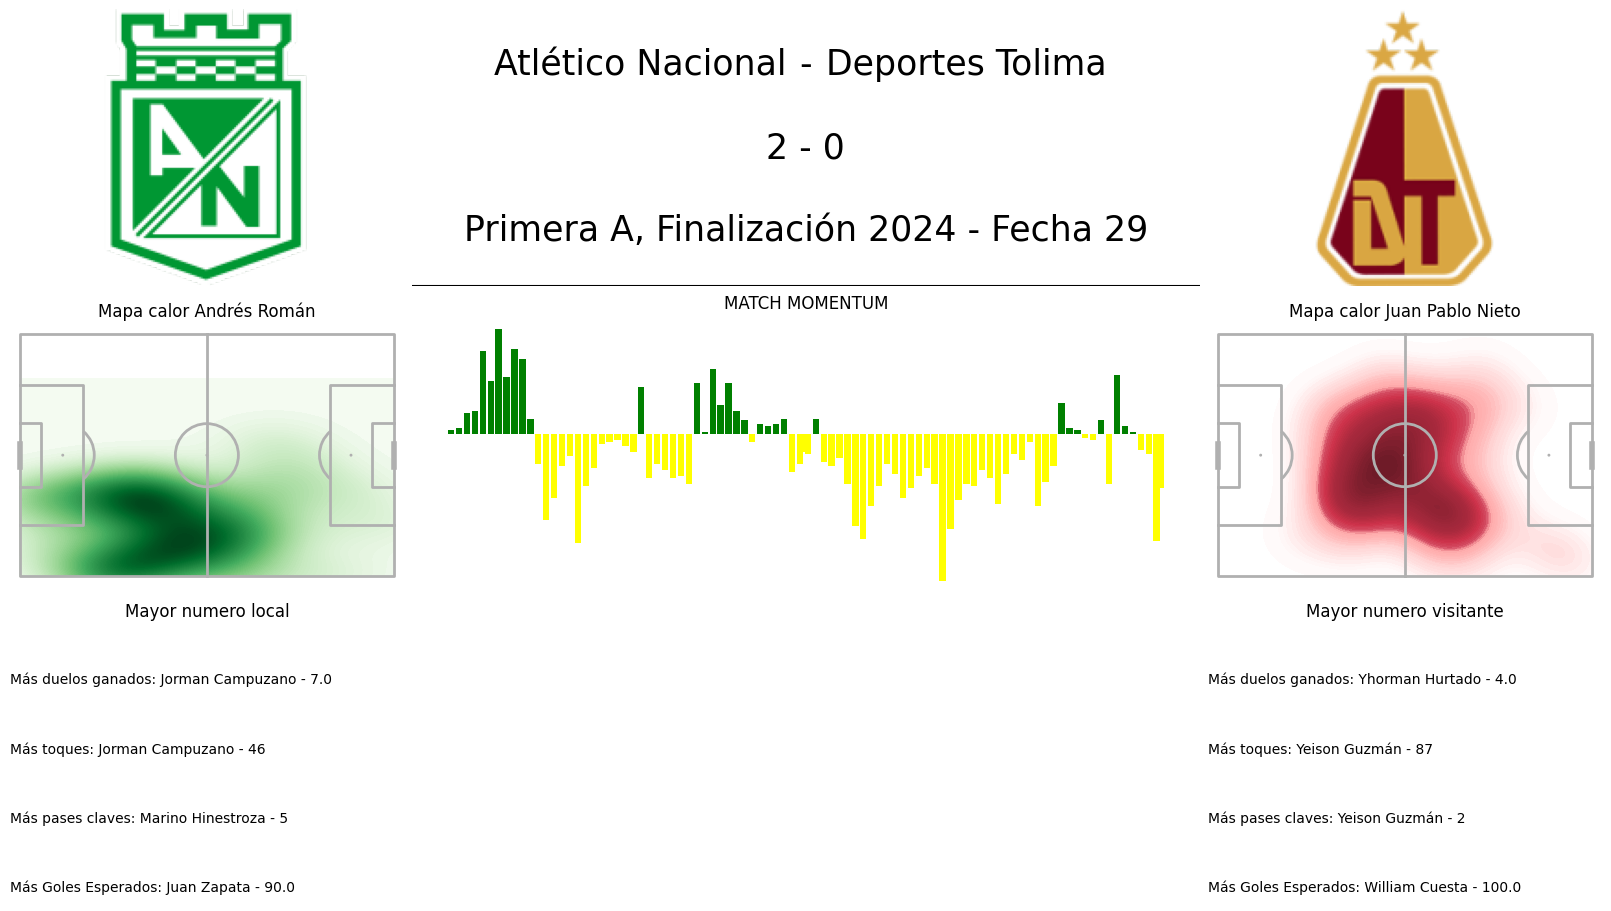

In [21]:
fig = plt.figure(figsize=(16,9),constrained_layout=True)
gs = fig.add_gridspec(nrows=3,ncols=4)
fig.set_facecolor('white')

#Escudo local
ax1 = fig.add_subplot(gs[0,0:1])
ax1.imshow(imagen1)
sacar_spines(ax1)

#Escudo visitante
ax2 = fig.add_subplot(gs[0,3:4])
ax2.imshow(imagen2)
sacar_spines(ax2)


ax3 = fig.add_subplot(gs[0,1:3])
ax3.text(.475,.8,f'{nombre_local}', ha='right', va='center', size=25)
ax3.text(.525,.8,f'{nombre_visit}', ha='left', va='center', size=25)
ax3.text(.5,.8,'-', ha='center', va='center', size=25)
ax3.text(.5,.5,f'{goleslocal} - {golesvisit}', ha='center', va='center', size=25)
ax3.text(.5,.2,f'{torneo} - Fecha {fecha}', ha='center', va='center', size=25)
ax3.axhline(0, color='black')
sacar_spines(ax3)


# Mapa de calor local
ax5 = fig.add_subplot(gs[1:2, :1])
ax5.set_title(f'Mapa calor {jug_heatmap_loc}')
# Dibujar el campo en el subplot correcto (ax5)
pitch_local = Pitch(pitch_type='opta')
pitch_local.draw(ax=ax5)  # Dibuja el campo en ax5

# Graficar el mapa de calor en el subplot correcto (ax5)
pitch_local.kdeplot(
    mapa_calor_jug_loc.x, 
    mapa_calor_jug_loc.y, 
    ax=ax5,
    levels=100,
    shade=True,
    zorder=-1,
    shade_lowest=True,
    cmap='Greens'  # Ajustar colormap si es necesario
)
sacar_spines(ax5)


# Mapa de calor visitante
ax6 = fig.add_subplot(gs[1:2,3:])
ax6.set_title(f'Mapa calor {jug_heatmap_vis}')
# Dibujar el campo en el subplot correcto (ax5)
pitch_visit = Pitch(pitch_type='opta')
pitch_visit.draw(ax=ax6)  # Dibuja el campo en ax5
# Graficar el mapa de calor en el subplot correcto (ax5)
pitch_visit.kdeplot(
    mapa_calor_jug_vis.x, 
    mapa_calor_jug_vis.y, 
    ax=ax6,
    levels=100,
    shade=True,
    zorder=-1,
    shade_lowest=True,
    cmap='granate_blanco'  # Ajustar colormap si es necesario
)
sacar_spines(ax6)


ax7 = fig.add_subplot(gs[1:2,1:3])
ax7.set_title('MATCH MOMENTUM')
match_momentum_local = match_momentum[match_momentum['value'] > 0]
match_momentum_visit = match_momentum[match_momentum['value'] < 0]
plt.bar(match_momentum_local.minute, match_momentum_local.value, color=color_loc)
plt.bar(match_momentum_visit.minute, match_momentum_visit.value, color=color_vis)
# Líneas verticales punteadas para momentos clave (opcional, por ejemplo, minuto 45, etc.)
ax.axvline(x=45, color='black', linestyle='--', linewidth=1)
ax.axvline(x=15, color='black', linestyle='--', linewidth=1)
ax.axvline(x=75, color='black', linestyle='--', linewidth=1)
# Añadir la línea horizontal en el valor 0
ax.axhline(0, color='black', linewidth=1.2)
sacar_spines(ax7)

"""
ax8 = fig.add_subplot(gs[2:,1:3])
ax8.set_title('MAPA DE TIROS')
pitch = VerticalPitch(
    pitch_type='statsbomb',
    goal_type='box'
)
pitch.draw(ax=ax8)
##plt.ylim(80, 125)
pitch.scatter(tiros.x, tiros.y, ax=ax)
plt.legend()
sacar_spines(ax8)
"""


ax10 = fig.add_subplot(gs[2:,:1])
ax10.set_title('Mayor numero local')
ax10.text(0,.8, f'Más duelos ganados: {nombre_mayores_local[0]} - {valor_mayores_local[0]}', ha='left', va='center')
ax10.text(0,.55, f'Más toques: {nombre_mayores_local[1]} - {int(valor_mayores_local[1])}', ha='left', va='center')
ax10.text(0,.3, f'Más pases claves: {nombre_mayores_local[2]} - {int(valor_mayores_local[2])}', ha='left', va='center')
ax10.text(0,.05, f'Más Goles Esperados: {nombre_mayores_local[3]} - {valor_mayores_local[3]}', ha='left', va='center')
sacar_spines(ax10)

ax9 = fig.add_subplot(gs[2:,3:])
ax9.set_title('Mayor numero visitante')
ax9.text(0,.8, f'Más duelos ganados: {nombre_mayores_visit[0]} - {valor_mayores_visit[0]}', ha='left', va='center')
ax9.text(0,.55, f'Más toques: {nombre_mayores_visit[1]} - {int(valor_mayores_visit[1])}', ha='left', va='center')
ax9.text(0,.3, f'Más pases claves: {nombre_mayores_visit[2]} - {int(valor_mayores_visit[2])}', ha='left', va='center')
ax9.text(0,.05, f'Más Goles Esperados: {nombre_mayores_visit[3]} - {valor_mayores_visit[3]}', ha='left', va='center')
sacar_spines(ax9)

In [22]:
plt.colormaps()

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viridis_r',
 'cividis_r',
 'twilight_r',
 'twilight